# Defacing pre-registration - Statistical analysis on manual ratings in R

## Load simulated manual ratings

In [3]:
df_full <- readRDS(file="SimulatedData/SimulatedDefacedRatings_noMissing_12raters.Rda")
df_missing <- readRDS(file="SimulatedData/SimulatedDefacedRatings_10%Missing.Rda")

#Define the number of raters in the dataset
n_rater = length(unique(df_full$rater))

In [4]:
source("simulate_data.R")

The simulated data were generated by running the `simulate_data.R` function.

## Linear mixed effect regression

Because the continuation ratio model implementation could not deal with missing values, we are switching to linear mixed effect regression model. It has been shown that considering linear regression on ordinal data is ok, as long as the probabilities of belonging to each category are far from the extremes.

### Do I need interaction terms in my model ?

We use an interaction plot to figure if an interaction between the defacing status and the rater is present. If the lines are not parallel, an interaction exists. Plot construction based on https://stattrek.com/multiple-regression/interaction.

In [ ]:
#Compute mean rating for each rater and each condition
mean_defaced = c()
mean_original = c()
for (i in 1:n_rater){
    df_small_defaced <- subset(df_full, defaced == 'defaced' & rater == sprintf('rater%02d', i))
    df_small_original <- subset(df_full, defaced == 'original' & rater == sprintf('rater%02d', i))
    mean_defaced[i] <- mean(as.numeric(df_small_defaced$ratings))
    mean_original[i] <- mean(as.numeric(df_small_original$ratings))
}

#Interaction plot
plot(c(0,1), c(mean_original[i], mean_defaced[i]),
    ylab="Mean rating",
    xlab="Defaced status",
    main ='Defaced * rater',
    ylim = c(2.4,3.3),
    type="o",
    col="blue")
for (i in 2:n_rater){ 
    lines(c(0,1), c(mean_original[i], mean_defaced[i]), type='o')
}

In the plot above, one line represents the evolution of the mean rating before and after defacing for one rater. The lines are not parallel, so we have to include the interaction term into the model. I interpret it as different raters are differently biased by the defacing process.
BUT we need to reduce the number of raters, because too many raters implies too many coefficients to estimate, hence the model doesn't converge.

We see two ways of including the interaction defaced/rater in the model, via fixed effects or via random slope. Below we try both models to figure out which makes more sense.

### First possible model

The first possible model is to allow for random intercept and slope for each rater.

In [84]:
## Load data
n_rated <- 580
n_sub <- 580 #nbr of subjects available in the dataset
n_rater <- 160 #nbr of raters
#perc_biased <- c(2,40,60,90) #4 raters + bias
perc_biased <- rep(c(2,10,20,40,50,60,60,80,80,90), times = n_rater/10)

df_4 <- simulate_data(n_rated, n_sub, n_rater, perc_biased)

## Fit model
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_4)
summary(fm1)
ranef(fm1)

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced + (defaced | rater)
   Data: df_4

REML criterion at convergence: 555051.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.10529 -0.82993  0.09458  0.87632  1.48522 

Random effects:
 Groups   Name           Variance  Std.Dev. Corr
 rater    (Intercept)    0.0005575 0.02361      
          defaceddefaced 0.0440563 0.20990  0.38
 Residual                1.1614577 1.07771      
Number of obs: 185600, groups:  rater, 160

Fixed effects:
               Estimate Std. Error t value
(Intercept)     2.49917    0.00400  624.79
defaceddefaced  0.36818    0.01733   21.24

Correlation of Fixed Effects:
            (Intr)
defaceddfcd -0.011

$rater
           (Intercept) defaceddefaced
rater01  -0.0039075267   -0.286838378
rater02  -0.0207554763   -0.298266473
rater03  -0.0130256153   -0.215882543
rater04  -0.0154365499   -0.101038147
rater05  -0.0049874682   -0.007675855
rater06  -0.0028372314    0.064321647
rater07   0.0088376244    0.089604234
rater08   0.0058062589    0.204932132
rater09  -0.0189854524    0.135844529
rater10   0.0159814843    0.291959113
rater11  -0.0123069405   -0.317947885
rater12  -0.0113205928   -0.272875455
rater13   0.0021536709   -0.154038599
rater14  -0.0107554674   -0.081765576
rater15   0.0026545865    0.020749499
rater16   0.0064201105    0.107860025
rater17   0.0055621825    0.095431154
rater18   0.0046338611    0.207482966
rater19  -0.0031451218    0.175889955
rater20   0.0082709655    0.261949931
rater21  -0.0071423551   -0.302326472
rater22  -0.0146966037   -0.276793252
rater23  -0.0124736485   -0.217949874
rater24   0.0042911450   -0.037827240
rater25   0.0114732933    0.031886068
rater

The problem is that this model converges to a singular solution. Thus we want to see if switching to continuous ratings solves this issue.

In [85]:
## Simulate continuous data with bias
n_rated <- 580
n_sub <- 580 #nbr of subjects available in the dataset
n_rater <- 90 #nbr of raters
#perc_biased <- c(2,40,60,90) #4 raters + bias
perc_biased <- rep(c(2,10,20,40,50,60,60,80,80,90), times = n_rater/10)
ratings_range <- seq(0,1,length.out=11)
labels <- c('excluded','0.1','poor','0.3','acceptable','0.5','good','0.7','very good','0.9','excellent')
bias <- 0.2

source("simulate_data.R")

df_cont <- simulate_data(n_rated, n_sub, n_rater, perc_biased, ratings_range=ratings_range, labels=labels, bias=bias)

## Fit model
library(lme4)
fm1_cont <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_cont)
summary(fm1_cont)
ranef(fm1_cont)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced + (defaced | rater)
   Data: df_cont

REML criterion at convergence: 534061.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.18496 -0.93299 -0.00059  0.94203  1.63595 

Random effects:
 Groups   Name           Variance Std.Dev. Corr
 rater    (Intercept)    0.003325 0.05766      
          defaceddefaced 0.222100 0.47128  1.00
 Residual                9.728720 3.11909      
Number of obs: 104400, groups:  rater, 90

Fixed effects:
               Estimate Std. Error t value
(Intercept)     5.99931    0.01494  401.46
defaceddefaced  0.84973    0.05330   15.94

Correlation of Fixed Effects:
            (Intr)
defaceddfcd 0.145 
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular


$rater
          (Intercept) defaceddefaced
rater01 -0.0866886990   -0.708534017
rater02 -0.0731066403   -0.597523576
rater03 -0.0453823038   -0.370923850
rater04 -0.0016209481   -0.013248519
rater05  0.0068001350    0.055579643
rater06  0.0164994194    0.134854947
rater07  0.0270805765    0.221338073
rater08  0.0532855961    0.435519945
rater09  0.0623584010    0.509674834
rater10  0.1053087463    0.860721523
rater11 -0.0892359250   -0.729353297
rater12 -0.0730268644   -0.596871543
rater13 -0.0592852540   -0.484557037
rater14 -0.0178766542   -0.146111520
rater15  0.0081739148    0.066807978
rater16  0.0403012250    0.329394594
rater17  0.0231845499    0.189494623
rater18  0.0302326157    0.247100682
rater19  0.0694931317    0.567989234
rater20  0.0591112826    0.483135115
rater21 -0.0838481115   -0.685317001
rater22 -0.0579953255   -0.474014046
rater23 -0.0721618200   -0.589801263
rater24 -0.0294459641   -0.240671131
rater25  0.0025375972    0.020740580
rater26  0.0318592382    0.2603

In [57]:
?isSingular

#### Visualize random effects

We extract the regression coefficients and overlay the resulting regression lines on the data to get a sense of the data fit

In [23]:
# see group coefficients
# see group coefficients
model_coefs <- coef(fm1_cont)$rater %>%
  rename(Intercept = `(Intercept)`, Slope = defaceddefaced) %>% 
  rownames_to_column("rater")

# see coefficients
model_coefs

rater,Intercept,Slope
<chr>,<dbl>,<dbl>
rater01,5.961159,0.05921059
rater02,5.972407,0.17707319
rater03,6.055049,1.04302952
rater04,6.099317,1.50689359


First, we’ll join these coefficients to our original data so we can plot the individual lines.

In [24]:
library(tidyverse)
fm1_groups <- left_join(df_cont, model_coefs, by = "rater")

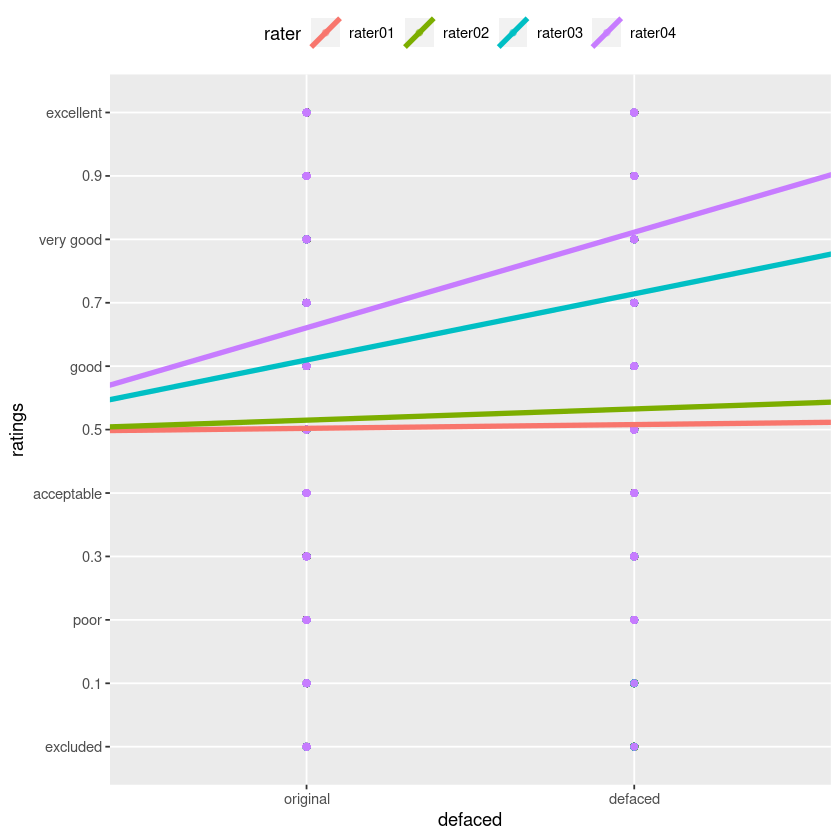

In [25]:
library(ggplot2)
model_coef_plot <- ggplot(data = fm1_groups, 
       mapping = aes(x = defaced, 
                     y = ratings, 
                     colour = rater)
       ) +
  geom_point(na.rm = T, alpha = 0.5) +
  geom_abline(aes(intercept = Intercept, 
                  slope = Slope,
                  colour = rater
                  ),
              size = 1.5
              ) +
  theme(legend.position = "top")

# see the plot
model_coef_plot

### Second possible model

The second possible model is to include the interaction defaced*rater as a fixed effect.

In [8]:
## Second possible model
fm2 <- lmer(as.numeric(ratings) ~ defaced*rater + (1 | rater), data=df_4)
summary(fm2)
ranef(fm2)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(ratings) ~ defaced * rater + (1 | rater)
   Data: df_4

REML criterion at convergence: 13975.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9733 -0.8559  0.0634  0.7845  1.4185 

Random effects:
 Groups   Name        Variance Std.Dev.
 rater    (Intercept) 0.000    0.000   
 Residual             1.183    1.088   
Number of obs: 4640, groups:  rater, 4

Fixed effects:
                            Estimate Std. Error t value
(Intercept)                  2.54483    0.04517  56.340
defaceddefaced               0.01724    0.06388   0.270
raterrater02                -0.08793    0.06388  -1.377
raterrater03                -0.06552    0.06388  -1.026
raterrater04                -0.08793    0.06388  -1.377
defaceddefaced:raterrater02  0.06207    0.09034   0.687
defaceddefaced:raterrater03  0.43448    0.09034   4.810
defaceddefaced:raterrater04  0.67241    0.09034   7.443

Correlation of Fixed Effects:
            (

$rater
        (Intercept)
rater01           0
rater02           0
rater03           0
rater04           0

with conditional variances for “rater” 

#### Visualize fixed effect regression coefficients

Loading required package: coda



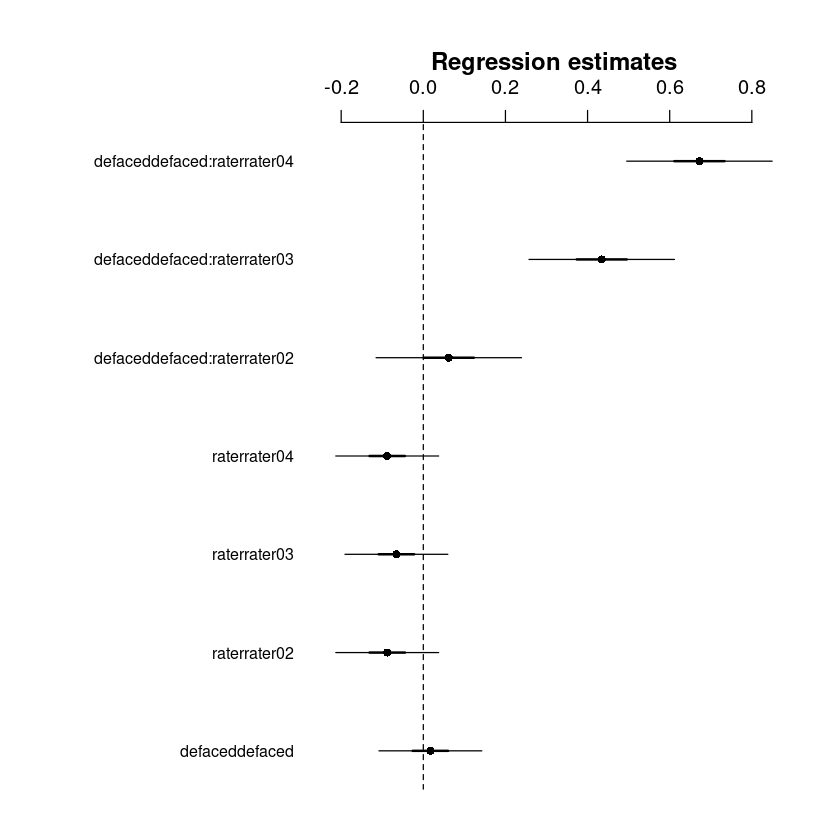

In [9]:
library(coefplot2)
coefplot2(fm2)

The thick bars correspond to ±1SD or 50% credible intervals and the thin lines to ±2SD or 95% CI

### Which formula ?

I am not sure whether we should include the interaction between defaced and rater as an interaction term in the fixed effect or as a random slope in the random effects.
Therefore I'm running an log likelihood ratio test to compare both models.

In [16]:
anova(fm1, fm2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm1,6,13972.73,14011.39,-6980.367,13960.73,NA,NA,NA
fm2,10,13960.84,14025.26,-6970.418,13940.84,19.89701,4,0.0005233292


For AIC and BIC smaller is better; for log-likelihood higher is better; chi2 and p-value should be significant for the model to be significantly better. Thus, including the interaction term has a mixed effect seems to model the data better.

### Test for significance

To test whether defacing significantly biases the human ratings, we compute p-values associated with its regression coefficient. The p-value is computed using Satterthwaite approximation for degrees of freedom. You can find the justification of why we chose to test significance using Satterthwaite approximation in the following paper : https://link.springer.com/article/10.3758/s13428-016-0809-y#appendices.

In [ ]:
library(lmerTest)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_full)
anova(fm1)
summary(fm1)

### How to deal with missing values

List the different options available to deal with missing values.

In [ ]:
getOption("na.action")

In [ ]:
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (1 | rater), data=df_missing, na.action=na.exclude)
summary(fm1)
ranef(fm1)

### Verify that the null hypothesis is not rejected if no bias has been introduced

In [ ]:
## Simulate data without bias
n_rated <- 580
n_sub <- 580 #nbr of subjects available in the dataset
n_rater <- 4 #nbr of raters
perc_biased <- c(0.5,0.5,0,0) #4 raters + no bias
file_name="SimulatedData/SimulatedDefacedRatings_4raters_nobias.Rda"

df_4_no_bias <- simulate_data(n_rated, n_sub, n_rater, perc_biased, file=file_name)

## Lmer should not find significant result
libray(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_4_no_bias)
summary(fm1)
ranef(fm1)